## Загрузка библиотек

In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import os
import time
import glob

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

from PIL import Image
import cv2

%matplotlib inline

In [3]:
%load_ext tensorboard

In [4]:
import warnings

warnings.filterwarnings('ignore')

## Загрузка данных

In [5]:
# Подготовка трансформеров с аугментацией

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
resize_dim = 256
size_dim = 224

ttransform = transforms.Compose([
    transforms.Resize(resize_dim),
    transforms.RandomResizedCrop(size_dim),
    transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
])

vtransform = transforms.Compose([
    transforms.Resize(resize_dim),
    transforms.CenterCrop(size_dim),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
])

In [6]:
# Мы создаем класс MyDataset и передаем аргумент Dataset, 
# чтобы он мог наследовать функционал класса Torch Dataset

path = "data/"

class MyDataset(Dataset):
    def __init__(self, train_flag = 'train', my_path = path):
        if train_flag == 'train':
            self.imgs_path = my_path + 'train/'
            self.selebrity = ImageFolder(self.imgs_path, transform = ttransform)
            self.transform = ttransform
        else:
            self.imgs_path = my_path + 'valid/'
            self.selebrity = ImageFolder(self.imgs_path, transform = vtransform)
            self.transform = vtransform

            
        self.classes = self.selebrity.classes
        self.img_dim = (size_dim, size_dim)        
        self.class_map = dict(zip(self.classes, list(range(len(self.classes)))))

    def __len__(self):
        return len(self.selebrity)

    def __getitem__(self, idx):
        image, class_id = self.selebrity[idx]
        return image, class_id

In [7]:
# Создание датасетов

train_dataset = MyDataset(train_flag = 'train')
valid_dataset = MyDataset(train_flag = 'valid')

In [8]:
# Создание загрузчика

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


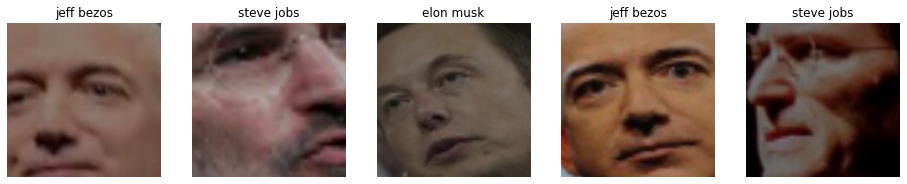

In [9]:
# Просмотр случайных изображений в датасете и контроль класса

def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        
        random_image = random_image.numpy().transpose((1,2,0))[:,:,]*std + mean
        
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

plot_samples(train_dataset)

### Загрузка модели

In [10]:
from torchvision.models import resnet50

In [11]:
class SelebrityModel(pl.LightningModule):

    def __init__(self):
        super().__init__()

        # используем предобученную модель ResNet-50
        self.net = models.resnet50(pretrained = True)
        
        # замораживаем веса
        for parameter in self.net.parameters():
            parameter.requres_grad = False
        
        # заменяем полносвязный слой на новый под нужное количество классов
        self.net.fc = torch.nn.Linear(2048, len(train_dataset.classes))

    # вызов модуля
    def forward(self, x):
        return self.net(x)

    # шаг обучения
    def training_step(self, batch, batch_nb):
        images, target = batch
        output = self(images)
        
        # используем "функциональную" версию функции потерь вместо инстанцирования модуля
        loss = F.cross_entropy(output, target)
        with torch.no_grad():
            top1 = torch.mean((output.argmax(1) == target).float()).item()

        # логируем метрики — они будут как в прогрессбаре внизу, так и в отдельной директории
        self.log('loss/train', loss, on_step=False, on_epoch=True)
        self.log('top1/train', top1, on_step=False, on_epoch=True, prog_bar=True)

        # нужно вернуть основное значение лосса (функции потерь)
        return loss

    def validation_step(self, batch, batch_idx):

        images, target = batch
        output = self(images)
 
        # используем "функциональную" версию функции потерь вместо инстанцирования модуля
        loss = F.cross_entropy(output, target)
        top1 = torch.mean((output.argmax(1) == target).float()).item()

        self.log('loss/val', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('top1/val', top1, on_step=False, on_epoch=True, prog_bar=True)

    # используемые оптимизаторы
    def configure_optimizers(self):
        return torch.optim.SGD(self.net.parameters(), lr=1e-2, weight_decay=1e-4)

### Обучение модели

In [12]:
# Инициализируем модуль
Selebrity_model = SelebrityModel()

In [13]:
# Инициализируем обучатель

if torch.cuda.is_available():
    gpus = -1 
else:
    gpus = None
    
Trainer = pl.Trainer(
    gpus=gpus,
    # обучаем в течение 30-ти эпох
    max_epochs=30,
    # обновляем прогрессбар каждые 10 итераций
    progress_bar_refresh_rate=10
)

# Обучаем модель обучателем на нашем датасете
Trainer.fit(Selebrity_model, train_loader, valid_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | net  | ResNet | 23.5 M
--------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.073    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Анализ обученной модели

#### Визуализация результатов с помощью tensorboard

In [17]:
%reload_ext tensorboard

In [18]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 14596), started 10:54:10 ago. (Use '!kill 14596' to kill it.)

#### Основная цель — добиться accuracy > 0.85 на валидационной выборке перевыполнена - достигнутый результат 0.98

### Тестирование модели на группе фотографий из интернета для окончательного теста

In [19]:
# Демонстрация фото с отметкой личности 

def show(img, title = None):
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

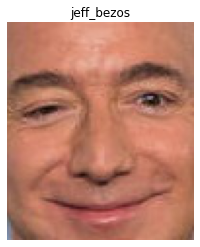

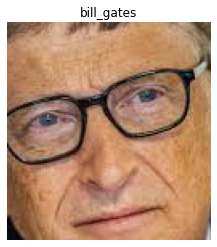

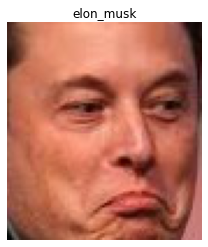

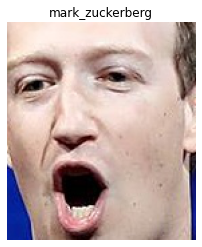

In [20]:
# Контроль отдельных фотографий в каталоге path 

Selebrity_model.eval()

for image_path in glob.glob(path + "*.jpg"):
    image = Image.open(image_path)
    tensor = valid_dataset.transform(image)
    output = Selebrity_model(torch.stack([tensor]))
    show(image, title=valid_dataset.classes[output.argmax().item()])